In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os

In [2]:
alpha = 1
beta = 0

# initial step size
eta0 = 1
# initial probability for beta > 0
prob0 = 0.5
# initial probability for beta = 0
prob00 = 0.1


d1 = 5
d2 = 2
mu = 1
var = 1

In [3]:
prob_seed = 1
np.random.seed(prob_seed)
# mat_S = np.random.randn(d1, d1) / np.sqrt(d1)
# mat_S = mat_S @ mat_S.T
# mat_S = mat_S + mu * np.identity(d1)
# vec_b = np.random.randn(d1)

mat_A = np.random.randn(d1, d1 - d2)
proj_A = mat_A @ np.linalg.inv(mat_A.T @ mat_A) @ mat_A.T
proj_A_bot = np.identity(d1) - proj_A
print(proj_A_bot @ proj_A_bot - proj_A_bot)

[[-2.77555756e-16 -1.11022302e-16  5.55111512e-17  1.04083409e-17
  -2.35922393e-16]
 [-1.11022302e-16 -1.11022302e-16  5.55111512e-17 -1.38777878e-17
  -1.66533454e-16]
 [ 8.32667268e-17  8.32667268e-17  0.00000000e+00  0.00000000e+00
   6.07153217e-17]
 [-2.08166817e-17 -2.77555756e-17  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.94289029e-16 -1.38777878e-16  1.02348685e-16 -2.77555756e-17
  -8.32667268e-17]]


In [17]:
[eig_D, eig_U] = np.linalg.eigh(proj_A_bot)
U1 = eig_U[:,eig_D < 1e-8]
U2 = eig_U[:,eig_D > 1e-8]
# sol = U2 @ np.linalg.inv(U2.T @ mat_S @ U2) @ U2.T @ vec_b




[2. 2. 2. 1. 1.]


In [209]:
# generate the degenerate exapmle in FL settings



# generate the vector b in a FL sample
# ss: the diagonal values of the matrix S
# k: the parameter degeneration
# dim: the dimension of the matrix S
def gen_b(ss, k, dim, n_client, prob_seed = 1):
    np.random.seed(prob_seed)
    if not isinstance(k, int) or k < 1 or k > n_client:
        raise ValueError('Wrong value of k')
    if ss.shape[0] != n_client or ss.shape[1] != dim:
        raise ValueError('Wrong shape of ss')
    
    coef_vec = np.zeros(n_client)
    b_list = []
    for j in range(dim):
        coef_mat = []
        for i in range(1, k+1):
            s = ss[:, j]
            coef_mat.append( np.sum(s ** (i+1)).repeat(n_client) - np.sum(s) * s ** i)
        for i in range(k+1, n_client+1):
            coef_mat.append(np.random.randn(n_client))
        coef_mat = np.array(coef_mat)
        coef_vec[k-1] = 5
        b_list.append( np.linalg.solve(coef_mat, coef_vec) )
    return np.array(b_list)
    
        




In [221]:
k = 2
dim = 2
n_client = 5
prob_seed = 2
s = np.random.randn(n_client, dim) ** 2 + 1
vec_b = gen_b(s, k, dim, n_client, prob_seed).T


# sol = np.sum(b) / np.sum(s)
print(vec_b.shape)

mat_S_list = []
for i in range(n_client):
    mat_S_list.append(np.diag(s[i,:]))
mat_S = np.array(mat_S_list)

mat_S_ave = np.mean(mat_S, axis=0)
vec_b_ave = np.mean(vec_b, axis=0)
sol = np.linalg.inv(mat_S_ave) @ vec_b_ave
print(sol)

(5, 2)
[0.0079129  0.11042223]


In [224]:
# for k = 2

alpha_list = [1.0, 0.8]
# alpha_list = [1.0, 0.8, 0.6]
# alpha_list = [1.0]
# alpha_list = [0.8, 0.6]
# beta_list = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
beta_list = [0.0, 0.4, 0.75, 0.8, 0.85, 0.9, 0.95]

# seed = 0
# eta0 = 1 # initial value for alpha = 1
# # eta0 = 0.5
# eta00 = 0.1 # initial value for alpha < 1

# seed = 1
eta0 = 1
eta00 = 0.2

prob00 = 0.1 # initial value for beta = 0
prob0 = 0.5 # initial value for beta > 0
n_ite = 100000
n_rep = 10

store_path = '../workspace/LPSA/fl_dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'

# np.random.seed(0)
# x00 = np.random.randn(n_client, dim)

for alpha in alpha_list:
    for beta in beta_list:
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
        path = store_path + para + '/'
        if not os.path.exists(path):
            os.makedirs(path)
            
        if alpha > 0.99:
            eta_ini = eta0
        else:
            eta_ini = eta00
        # print(eta_ini)

        for j in range(n_rep):
#             np.random.seed(j)
            x0 = np.random.randn(n_client, dim)
#             x0 = np.random.randn(n_client)
            u_list = []
            v_list = []
            mse_list = []
            loss_list = []
            eta_list = []
            f_list = []
            x = x0
            for i in range(n_ite):
                eta = eta_ini / (i+1) ** alpha
                noise = np.sqrt(var) * np.random.randn(n_client, dim)
#                 print(mat_S.shape, x.shape)
                grad = np.sum(mat_S * np.expand_dims(x, axis=1).repeat(dim, axis=1), axis=2) - vec_b
#                 grad = s * x - b
                x = x - eta * (grad + noise)
                u = np.mean(x, axis=0)

                if beta > 0.01:
                    prob = prob0 * eta ** beta
                else:
                    prob = prob00
                prob = min(prob, 1)
                f = np.random.binomial(1, prob)

                if f > 0:
                    x = np.repeat(np.expand_dims(u, axis=0), 5, axis=0)
#                     x = np.repeat(u, n_client)
                v = x - u
                u_list.append(u - sol)
                v_list.append(v)
                mse = np.linalg.norm(u - sol) ** 2
#                 loss = np.dot(mat_S @ u, u) / 2 - np.dot(u, vec_b)
                mse_list.append(mse)
#                 loss_list.append(loss - loss_min)
                eta_list.append(eta)
                f_list.append(f)

            np.save(path + 'mse' + str(j) + '.npy', np.array(mse_list))
#             np.save(path + 'loss' + str(j) + '.npy', np.array(loss_list))
#             np.save(path + 'eta' + str(j) + '.npy', np.array(eta_list))
#             np.save(path + 'u' + str(j) + '.npy', np.array(u_list))
#             np.save(path + 'v' + str(j) + '.npy', np.array(v_list))
            np.save(path + 'f' + str(j) + '.npy', np.array(f_list))

        print(para, j, 'done\n')

alpha1.0beta0.0 9 done

alpha1.0beta0.4 9 done

alpha1.0beta0.75 9 done

alpha1.0beta0.8 9 done

alpha1.0beta0.85 9 done

alpha1.0beta0.9 9 done

alpha1.0beta0.95 9 done

alpha0.8beta0.0 9 done

alpha0.8beta0.4 9 done

alpha0.8beta0.75 9 done

alpha0.8beta0.8 9 done

alpha0.8beta0.85 9 done

alpha0.8beta0.9 9 done

alpha0.8beta0.95 9 done



<Figure size 640x480 with 0 Axes>

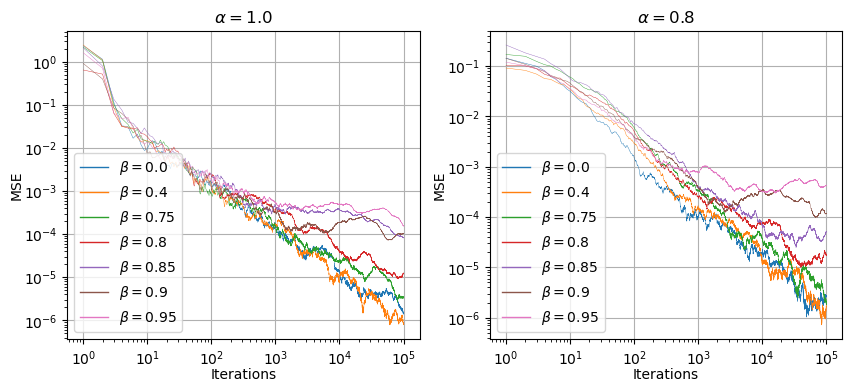

In [225]:
# plot: convergence rate

s = 1
num_ite = n_ite
# num_ite = 10000
# num_ite = 100000
# beta_list = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
# load_path = '../workspace/LPSA/mse_seed' + str(prob_seed) + '/'
# load_path = '../workspace/LPSA/fl_dege_mse_seed' + str(prob_seed) + '/'
load_path = '../workspace/LPSA/fl_dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'

plt.clf()
j = 0
plt.figure(figsize = (10, 4))
for alpha in alpha_list:
    j = j + 1
    ax1 = plt.subplot(1, 2, j)
    for beta in beta_list:
        u_data = []
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
#         alpha = para[2:5]
#         beta = para[9:]
        path = load_path + para + '/' 
        for i in range(n_rep):
            u_data.append(np.load(path + 'mse' + str(i) + '.npy'))
        u_data = np.array(u_data)
        u_data = np.mean(u_data, 0)
        legend_tmp = r'$\beta=$' + str(beta)
        plt.loglog(np.arange(len(u_data))[s:num_ite], u_data[s:num_ite], label=legend_tmp, linewidth=0.3)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(1)
    plt.grid()
    plt.xlabel('Iterations', labelpad=0.5)
    plt.ylabel('MSE', labelpad=0)
#     plt.ylim([1e-6, 1e-0])
    plt.title(r'$\alpha=$' + str(alpha))

# plt.savefig('./fl_convergence.pdf', bbox_inches='tight')

In [228]:

k = 3
dim = 4
n_client = 5
prob_seed = 1
s = np.random.randn(n_client, dim) ** 2 + 1
vec_b = gen_b(s, k, dim, n_client, prob_seed).T

# sol = np.sum(b) / np.sum(s)
print(vec_b.shape)

mat_S_list = []
for i in range(n_client):
    mat_S_list.append(np.diag(s[i,:]))
mat_S = np.array(mat_S_list)

mat_S_ave = np.mean(mat_S, axis=0)
vec_b_ave = np.mean(vec_b, axis=0)
sol = np.linalg.inv(mat_S_ave) @ vec_b_ave
print(sol)

(5, 4)
[-2.44229192e+01 -2.80397136e+00 -4.58656947e-01  1.66341943e-02]


In [240]:
# for k = 3

alpha_list = [1.0, 0.8]
# alpha_list = [1.0]
# alpha_list = [0.8, 0.6]
# beta_list = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
# beta_list = [0.0, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]
beta_list = [0.0, 0.4, 0.83, 0.87, 0.9, 0.95]

# seed = 0
# eta0 = 1 # initial value for alpha = 1
# # eta0 = 0.5
# eta00 = 0.1 # initial value for alpha < 1

# seed = 1
eta0 = 1
eta00 = 0.3

prob00 = 0.1 # initial value for beta = 0
prob0 = 0.5 # initial value for beta > 0
n_ite = 100000
n_rep = 10

store_path = '../workspace/LPSA/fl_dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'

# np.random.seed(0)
# x00 = np.random.randn(n_client, dim)

for alpha in alpha_list:
    for beta in beta_list:
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
        path = store_path + para + '/'
        if not os.path.exists(path):
            os.makedirs(path)
            
        if alpha > 0.99:
            eta_ini = eta0
        else:
            eta_ini = eta00
        # print(eta_ini)

        for j in range(n_rep):
#             np.random.seed(j)
            x0 = np.random.randn(n_client, dim)
#             x0 = np.random.randn(n_client)
            u_list = []
            v_list = []
            mse_list = []
            loss_list = []
            eta_list = []
            f_list = []
            x = x0
            for i in range(n_ite):
                eta = eta_ini / (i+1) ** alpha
                noise = np.sqrt(var) * np.random.randn(n_client, dim)
#                 print(mat_S.shape, x.shape)
                grad = np.sum(mat_S * np.expand_dims(x, axis=1).repeat(dim, axis=1), axis=2) - vec_b
#                 grad = s * x - b
                x = x - eta * (grad + noise)
                u = np.mean(x, axis=0)

                if beta > 0.01:
                    prob = prob0 * eta ** beta
                else:
                    prob = prob00
                prob = min(prob, 1)
                f = np.random.binomial(1, prob)

                if f > 0:
                    x = np.repeat(np.expand_dims(u, axis=0), 5, axis=0)
#                     x = np.repeat(u, n_client)
                v = x - u
                u_list.append(u - sol)
                v_list.append(v)
                mse = np.linalg.norm(u - sol) ** 2
#                 loss = np.dot(mat_S @ u, u) / 2 - np.dot(u, vec_b)
                mse_list.append(mse)
#                 loss_list.append(loss - loss_min)
                eta_list.append(eta)
                f_list.append(f)

            np.save(path + 'mse' + str(j) + '.npy', np.array(mse_list))
#             np.save(path + 'loss' + str(j) + '.npy', np.array(loss_list))
#             np.save(path + 'eta' + str(j) + '.npy', np.array(eta_list))
#             np.save(path + 'u' + str(j) + '.npy', np.array(u_list))
#             np.save(path + 'v' + str(j) + '.npy', np.array(v_list))
#             np.save(path + 'f' + str(j) + '.npy', np.array(f_list))

        print(para, j, 'done\n')

alpha1.0beta0.0 9 done

alpha1.0beta0.4 9 done

alpha1.0beta0.83 9 done

alpha1.0beta0.87 9 done

alpha1.0beta0.9 9 done

alpha1.0beta0.95 9 done

alpha0.8beta0.0 9 done

alpha0.8beta0.4 9 done

alpha0.8beta0.83 9 done

alpha0.8beta0.87 9 done

alpha0.8beta0.9 9 done

alpha0.8beta0.95 9 done



<Figure size 640x480 with 0 Axes>

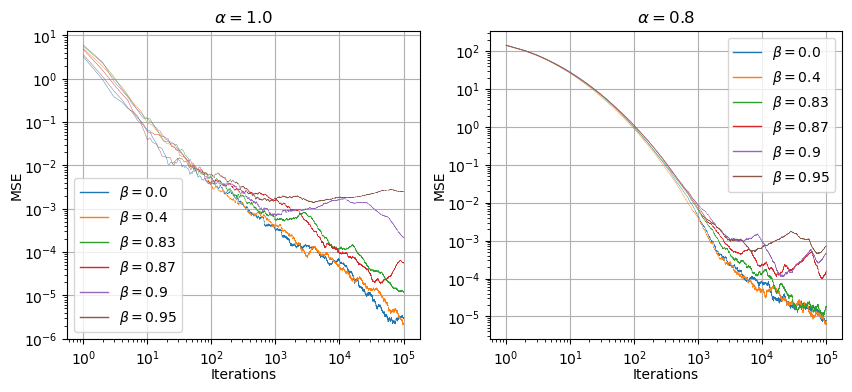

In [241]:
# plot: convergence rate

s = 1
# num_ite = 10000
num_ite = n_ite
# beta_list = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
# load_path = '../workspace/LPSA/mse_seed' + str(prob_seed) + '/'
# load_path = '../workspace/LPSA/fl_dege_mse_seed' + str(prob_seed) + '/'
load_path = '../workspace/LPSA/fl_dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'


plt.clf()
j = 0
plt.figure(figsize = (10, 4))
for alpha in alpha_list:
    j = j + 1
    ax1 = plt.subplot(1, 2, j)
    for beta in beta_list:
        u_data = []
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
#         alpha = para[2:5]
#         beta = para[9:]
        path = load_path + para + '/' 
        for i in range(n_rep):
            u_data.append(np.load(path + 'mse' + str(i) + '.npy'))
        u_data = np.array(u_data)
        u_data = np.mean(u_data, 0)
        legend_tmp = r'$\beta=$' + str(beta)
        plt.loglog(np.arange(len(u_data))[s:num_ite], u_data[s:num_ite], label=legend_tmp, linewidth=0.3)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(1)
    plt.grid()
    plt.xlabel('Iterations', labelpad=0.5)
    plt.ylabel('MSE', labelpad=0)
#     plt.ylim([1e-6, 1e-0])
    plt.title(r'$\alpha=$' + str(alpha))

# plt.savefig('./fl_convergence.pdf', bbox_inches='tight')

In [200]:
# generate the degenerate example in general settings

d1 = 5
d2 = 2
k = 2
prob_seed = 3
np.random.seed(prob_seed)
mat_S = np.random.randn(d1, d1) / np.sqrt(d1)
mat_S = mat_S @ mat_S.T
mat_S = mat_S + mu * np.identity(d1)
# let c = S x^star - b
vec_c = np.random.randn(d1)
tmp = np.array([vec_c, mat_S @ vec_c])
[mat_A0, _, _] = np.linalg.svd(tmp.T)
# construct the constrained matrix
mat_A = mat_A0[:,:3]
# construct a vector v lie in col(A^bot), in fact, v equals to x^star
vec_v = mat_A0[:,3]
vec_b = mat_S @ vec_v - vec_c
# print(mat_A.shape)
x_star = np.linalg.solve(mat_S, vec_c + vec_b)
print(x_star, mat_A.T @ x_star)

[-0.53108162  0.2979363  -0.104839    0.78177122 -0.08383801] [ 6.97225151e-17  7.18354663e-17 -1.86298883e-17]


In [206]:
print(np.linalg.norm(vec_v - x_star))

3.925231146709438e-17

In [201]:
# check the solution
proj_A = mat_A @ np.linalg.inv(mat_A.T @ mat_A) @ mat_A.T
proj_A_bot = np.identity(d1) - proj_A
proj_A_bot = np.identity(d1) - proj_A
[eig_D, eig_U] = np.linalg.eigh(proj_A_bot)

U1 = eig_U[:,eig_D < 1e-8]
U2 = eig_U[:,eig_D > 1e-8]
sol = U2 @ np.linalg.inv(U2.T @ mat_S @ U2) @ U2.T @ vec_b

print(x_star - sol, vec_c - mat_S @ sol + vec_b)
print(proj_A_bot @ vec_c, proj_A_bot @ mat_S @ vec_c, proj_A_bot @ mat_S @ mat_S @ vec_c)
print(proj_A_bot @ mat_S @ mat_S @ mat_S @ vec_c)

[ 0.00000000e+00  3.33066907e-16 -4.16333634e-17  2.22044605e-16
  1.11022302e-16] [ 0.00000000e+00  4.44089210e-16 -1.11022302e-16  4.44089210e-16
  1.11022302e-16]
[-5.55111512e-17  1.11022302e-16 -2.77555756e-17  5.55111512e-17
  1.38777878e-17] [ 0.00000000e+00  5.55111512e-17 -2.77555756e-17  2.22044605e-16
  0.00000000e+00] [-0.15059418  0.16200216 -0.06666611  0.20825007  0.25759273]
[-1.05093023  1.06657472 -0.4347531   1.46436725  1.56544954]


In [204]:
alpha = 1
beta = 0
alpha_list = [1.0, 0.8, 0.6]
# alpha_list = [1.0]
# beta_list = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
# beta_list = [0.0, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]
beta_list = [0.0, 0.4, 0.75, 0.8, 0.85, 0.9, 0.95]


# about eta0: 2 ~ 1 or 2e-6; 1 ~ 2e-6; 0.5 ~  1e-5
eta0 = 1
eta00 = 0.2
var = 1

d1 = 5
d2 = 2

n_ite = 100000
prob00 = 0.1
n_rep = 10

u_rep_list = []
v_rep_list = []
mse_rep_list = []
loss_rep_list = []
# x0 = np.random.randn(d1)

store_path = '../workspace/LPSA/dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'

for alpha in alpha_list:
    for beta in beta_list:
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
        path = store_path + para + '/'
        if not os.path.exists(path):
            os.makedirs(path)
            
        if alpha > 0.99:
            eta_ini = eta0
        else:
            eta_ini = eta00
        print(eta_ini)

        for j in range(n_rep):
#             np.random.seed(j)
            x0 = np.random.randn(d1)
            u_list = []
            v_list = []
            mse_list = []
            loss_list = []
            eta_list = []
            f_list = []
            x = x0
            for i in range(n_ite):
                eta = eta_ini / (i+1) ** alpha
                noise = np.sqrt(var) * np.random.randn(d1)
                x = x - eta * ((mat_S @ x - vec_b) + noise)
                u = proj_A_bot @ x

                if beta > 0.01:
                    prob = prob0 * eta ** beta
                else:
                    prob = prob00
                prob = min(prob, 1)
                f = np.random.binomial(1, prob)

                if f > 0:
                    x = u
                v = x - u
                u_list.append(u - sol)
                v_list.append(v)
                mse = np.linalg.norm(u - sol) ** 2
#                 loss = np.dot(mat_S @ u, u) / 2 - np.dot(u, vec_b)
                mse_list.append(mse)
#                 loss_list.append(loss - loss_min)
                eta_list.append(eta)
                f_list.append(f)
            
            np.save(path + 'mse' + str(j) + '.npy', np.array(mse_list))
#             np.save(path + 'loss' + str(j) + '.npy', np.array(loss_list))
#             np.save(path + 'eta' + str(j) + '.npy', np.array(eta_list))
#             np.save(path + 'u' + str(j) + '.npy', np.array(u_list))
#             np.save(path + 'v' + str(j) + '.npy', np.array(v_list))
#             np.save(path + 'f' + str(j) + '.npy', np.array(f_list))

1
1
1
1
1
1
1
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


<Figure size 640x480 with 0 Axes>

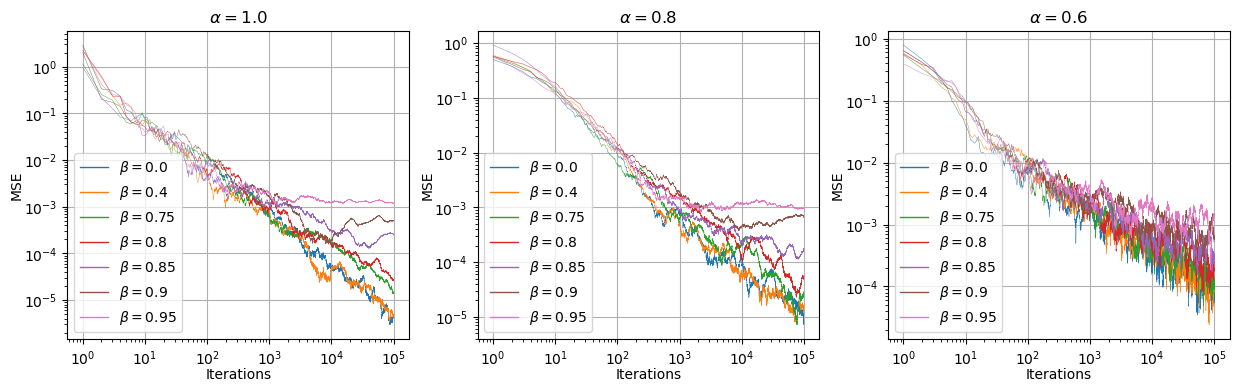

In [205]:
# plot: convergence rate

s = 1
num_ite = n_ite
# num_ite = 10000
# num_ite = 100000
# beta_list = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]

load_path = '../workspace/LPSA/dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'


plt.clf()
j = 0
plt.figure(figsize = (15, 4))
for alpha in [1.0, 0.8, 0.6]:
    j = j + 1
    ax1 = plt.subplot(1, 3, j)
    for beta in beta_list:
        u_data = []
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
#         alpha = para[2:5]
#         beta = para[9:]
        path = load_path + para + '/' 
        for i in range(n_rep):
            u_data.append(np.load(path + 'mse' + str(i) + '.npy'))
        u_data = np.array(u_data)
        u_data = np.mean(u_data, 0)
        legend_tmp = r'$\beta=$' + str(beta)
        plt.loglog(np.arange(len(u_data))[s:num_ite], u_data[s:num_ite], label=legend_tmp, linewidth=0.3)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(1)
    plt.grid()
    plt.xlabel('Iterations', labelpad=0.5)
    plt.ylabel('MSE', labelpad=0)
#     plt.ylim([1e-6, 1e-0])
    plt.title(r'$\alpha=$' + str(alpha))

# plt.savefig('./fl_convergence.pdf', bbox_inches='tight')

In [178]:
d1 = 20
d2 = 10

k = 3
prob_seed = 1
np.random.seed(prob_seed)
mat_S = np.random.randn(d1, d1) / np.sqrt(d1)
mat_S = mat_S @ mat_S.T
mat_S = mat_S + mu * np.identity(d1)
# let c = S x^star - b
vec_c = np.random.randn(d1)
tmp = np.array([vec_c, mat_S @ vec_c, mat_S @ mat_S @ vec_c])
[mat_A0, _, _] = np.linalg.svd(tmp.T)
# construct the constrained matrix
mat_A = mat_A0[:,:3]
# construct a vector v lie in col(A^bot), in fact, v equals to x^star
vec_v = mat_A0[:,3]
vec_b = mat_S @ vec_v - vec_c
# print(mat_A.shape)
x_star = np.linalg.solve(mat_S, vec_c + vec_b)
print(x_star, mat_A.T @ x_star)

[ 0.16520408 -0.52018536 -0.08520596  0.69035422  0.09221816 -0.05130104
 -0.05779543 -0.08608547 -0.20839379 -0.11618426  0.18540183  0.02977467
 -0.24081285 -0.11500422 -0.03913725  0.0584812   0.12403081 -0.07507898
  0.07422809 -0.03863661] [3.63402261e-17 1.63125188e-18 3.09750667e-17]


In [183]:
print(np.linalg.svd(mat_S)[1])

[4.23421804 3.64600481 3.56519284 3.00656966 2.70517748 2.33703929
 2.18090223 2.08050345 1.83185327 1.76327394 1.56081062 1.35629485
 1.26245452 1.22831711 1.16553163 1.12165119 1.03817828 1.02384777
 1.00456683 1.00017395]


In [179]:
# check the solution
proj_A = mat_A @ np.linalg.inv(mat_A.T @ mat_A) @ mat_A.T
proj_A_bot = np.identity(d1) - proj_A
[eig_D, eig_U] = np.linalg.eigh(proj_A_bot)

U1 = eig_U[:,eig_D < 1e-8]
U2 = eig_U[:,eig_D > 1e-8]
sol = U2 @ np.linalg.inv(U2.T @ mat_S @ U2) @ U2.T @ vec_b

print(np.linalg.norm(x_star - sol), np.linalg.norm(vec_c - mat_S @ sol + vec_b))
print(np.linalg.norm(proj_A_bot @ vec_c), np.linalg.norm(proj_A_bot @ mat_S @ vec_c), \
      np.linalg.norm(proj_A_bot @ mat_S @ mat_S @ vec_c))
print(np.linalg.norm(proj_A_bot @ mat_S @ mat_S @ mat_S @ vec_c))

1.700188310332992e-15 2.2002312397136254e-15
1.017607184943388e-15 3.4734414553320746e-15 1.9735756178897087e-14
2.624672693651746


In [184]:
print(np.linalg.norm(proj_A_bot @ vec_b))

1.4882922961646583


In [185]:
alpha = 1
beta = 0
alpha_list = [1.0, 0.8, 0.6]
# alpha_list = [1.0]
# beta_list = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
# beta_list = [0.0, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]
beta_list = [0.0, 0.4, 0.83, 0.87, 0.9, 0.95, 1]

eta0 = 1
eta00 = 0.2
var = 1



n_ite = 100000
prob00 = 0.1
n_rep = 10

u_rep_list = []
v_rep_list = []
mse_rep_list = []
loss_rep_list = []
# x0 = np.random.randn(d1)

store_path = '../workspace/LPSA/dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'

for alpha in alpha_list:
    for beta in beta_list:
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
        path = store_path + para + '/'
        if not os.path.exists(path):
            os.makedirs(path)
            
        if alpha > 0.99:
            eta_ini = eta0
        else:
            eta_ini = eta00
        print(eta_ini)

        for j in range(n_rep):
#             np.random.seed(j)
            x0 = np.random.randn(d1)
            u_list = []
            v_list = []
            mse_list = []
            loss_list = []
            eta_list = []
            f_list = []
            x = x0
            for i in range(n_ite):
                eta = eta_ini / (i+1) ** alpha
                noise = np.sqrt(var) * np.random.randn(d1)
                x = x - eta * ((mat_S @ x - vec_b) + noise)
                u = proj_A_bot @ x

                if beta > 0.01:
                    prob = prob0 * eta ** beta
                else:
                    prob = prob00
                prob = min(prob, 1)
                f = np.random.binomial(1, prob)

                if f > 0:
                    x = u
                v = x - u
                u_list.append(u - sol)
                v_list.append(v)
                mse = np.linalg.norm(u - sol) ** 2
#                 loss = np.dot(mat_S @ u, u) / 2 - np.dot(u, vec_b)
                mse_list.append(mse)
#                 loss_list.append(loss - loss_min)
                eta_list.append(eta)
                f_list.append(f)
#             print(np.sum(np.array(f_list)))
            np.save(path + 'mse' + str(j) + '.npy', np.array(mse_list))
#             np.save(path + 'loss' + str(j) + '.npy', np.array(loss_list))
#             np.save(path + 'eta' + str(j) + '.npy', np.array(eta_list))
#             np.save(path + 'u' + str(j) + '.npy', np.array(u_list))
#             np.save(path + 'v' + str(j) + '.npy', np.array(v_list))
            np.save(path + 'f' + str(j) + '.npy', np.array(f_list))

1
1
1
1
1
1
1
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


<Figure size 640x480 with 0 Axes>

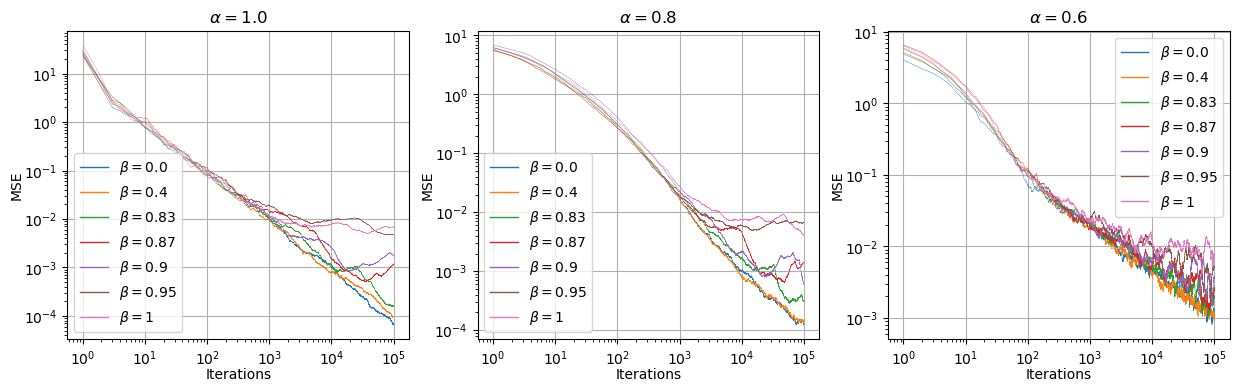

In [187]:
# plot: convergence rate

s = 1
num_ite = n_ite
# num_ite = 10000
# num_ite = 100000
# beta_list = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]

load_path = '../workspace/LPSA/dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'


plt.clf()
j = 0
plt.figure(figsize = (15, 4))
for alpha in [1.0, 0.8, 0.6]:
    j = j + 1
    ax1 = plt.subplot(1, 3, j)
    for beta in beta_list:
        u_data = []
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
#         alpha = para[2:5]
#         beta = para[9:]
        path = load_path + para + '/' 
        for i in range(n_rep):
            u_data.append(np.load(path + 'mse' + str(i) + '.npy'))
        u_data = np.array(u_data)
        u_data = np.mean(u_data, 0)
        legend_tmp = r'$\beta=$' + str(beta)
        plt.loglog(np.arange(len(u_data))[s:num_ite], u_data[s:num_ite], label=legend_tmp, linewidth=0.3)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(1)
    plt.grid()
    plt.xlabel('Iterations', labelpad=0.5)
    plt.ylabel('MSE', labelpad=0)
#     plt.ylim([1e-6, 1e-0])
    plt.title(r'$\alpha=$' + str(alpha))

# plt.savefig('./fl_convergence.pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

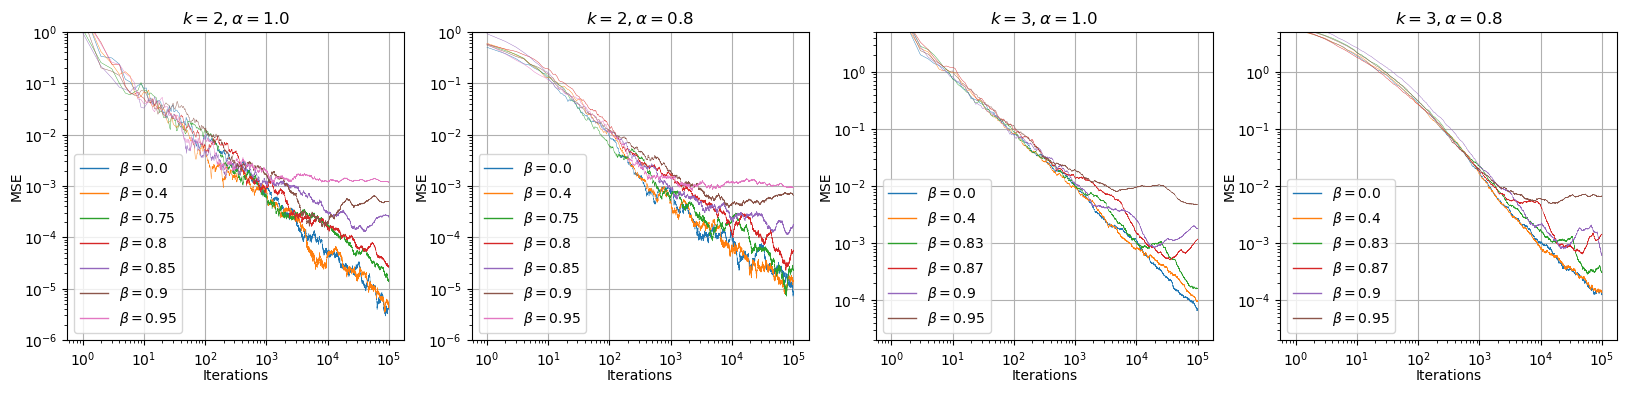

In [11]:
# plot formal

# general settings
s = 1
num_ite = 100000
alpha_list = [1.0, 0.8]
beta_list_k2 = [0.0, 0.4, 0.75, 0.8, 0.85, 0.9, 0.95]
beta_list_k3 = [0.0, 0.4, 0.83, 0.87, 0.9, 0.95]

plt.clf()
j = 0
plt.figure(figsize = (20, 4))

k = 2
prob_seed = 3
load_path = '../workspace/LPSA/dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'

for alpha in alpha_list:
    j = j + 1
    ax1 = plt.subplot(1, 4, j)
    for beta in beta_list_k2:
        u_data = []
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
#         alpha = para[2:5]
#         beta = para[9:]
        path = load_path + para + '/' 
        for i in range(n_rep):
            u_data.append(np.load(path + 'mse' + str(i) + '.npy'))
        u_data = np.array(u_data)
        u_data = np.mean(u_data, 0)
        legend_tmp = r'$\beta=$' + str(beta)
        plt.loglog(np.arange(len(u_data))[s:num_ite], u_data[s:num_ite], label=legend_tmp, linewidth=0.3)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(1)
    plt.grid()
    plt.xlabel('Iterations', labelpad=0.5)
    plt.ylabel('MSE', labelpad=0)
    plt.ylim([1e-6, 1e-0])
    plt.title(r'$k=$' + str(k) + r'$ ,\alpha=$' + str(alpha))
    
k = 3
prob_seed = 1
load_path = '../workspace/LPSA/dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'

for alpha in alpha_list:
    j = j + 1
    ax1 = plt.subplot(1, 4, j)
    for beta in beta_list_k3:
        u_data = []
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
#         alpha = para[2:5]
#         beta = para[9:]
        path = load_path + para + '/' 
        for i in range(n_rep):
            u_data.append(np.load(path + 'mse' + str(i) + '.npy'))
        u_data = np.array(u_data)
        u_data = np.mean(u_data, 0)
        legend_tmp = r'$\beta=$' + str(beta)
        plt.loglog(np.arange(len(u_data))[s:num_ite], u_data[s:num_ite], label=legend_tmp, linewidth=0.3)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(1)
    plt.grid()
    plt.xlabel('Iterations', labelpad=0.5)
    plt.ylabel('MSE', labelpad=0)
    plt.ylim([2e-5, 5e-0])
    plt.title(r'$k=$' + str(k) + r'$ ,\alpha=$' + str(alpha))
    
plt.savefig('./figs/lc_degenerate.pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

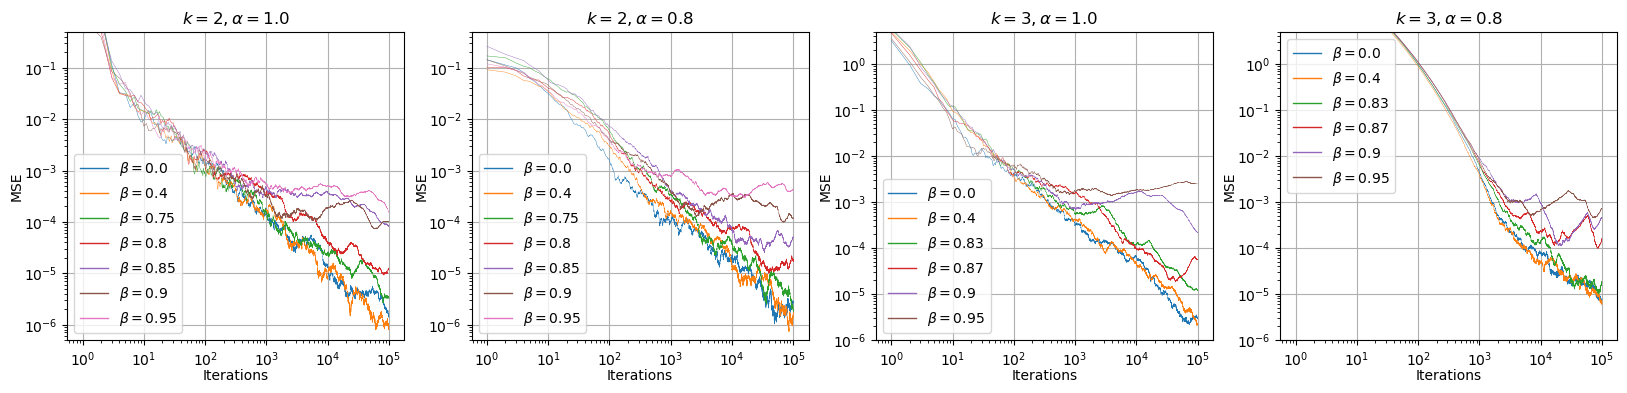

In [13]:
# plot formal

# FL settings
s = 1
num_ite = 100000
n_rep = 10
alpha_list = [1.0, 0.8]
beta_list_k2 = [0.0, 0.4, 0.75, 0.8, 0.85, 0.9, 0.95]
beta_list_k3 = [0.0, 0.4, 0.83, 0.87, 0.9, 0.95]

plt.clf()
j = 0
plt.figure(figsize = (20, 4))

k = 2
prob_seed = 2
load_path = '../workspace/LPSA/fl_dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'

for alpha in alpha_list:
    j = j + 1
    ax1 = plt.subplot(1, 4, j)
    for beta in beta_list_k2:
        u_data = []
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
#         alpha = para[2:5]
#         beta = para[9:]
        path = load_path + para + '/' 
        for i in range(n_rep):
            u_data.append(np.load(path + 'mse' + str(i) + '.npy'))
        u_data = np.array(u_data)
        u_data = np.mean(u_data, 0)
        legend_tmp = r'$\beta=$' + str(beta)
        plt.loglog(np.arange(len(u_data))[s:num_ite], u_data[s:num_ite], label=legend_tmp, linewidth=0.3)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(1)
    plt.grid()
    plt.xlabel('Iterations', labelpad=0.5)
    plt.ylabel('MSE', labelpad=0)
    plt.ylim([5e-7, 5e-1])
    plt.title(r'$k=$' + str(k) + r'$ ,\alpha=$' + str(alpha))
    
k = 3
prob_seed = 1
load_path = '../workspace/LPSA/fl_dege' + str(k) + '_mse_seed' + str(prob_seed) + '/'

for alpha in alpha_list:
    j = j + 1
    ax1 = plt.subplot(1, 4, j)
    for beta in beta_list_k3:
        u_data = []
        para = 'alpha' + str(alpha) + 'beta' + str(beta)
#         alpha = para[2:5]
#         beta = para[9:]
        path = load_path + para + '/' 
        for i in range(n_rep):
            u_data.append(np.load(path + 'mse' + str(i) + '.npy'))
        u_data = np.array(u_data)
        u_data = np.mean(u_data, 0)
        legend_tmp = r'$\beta=$' + str(beta)
        plt.loglog(np.arange(len(u_data))[s:num_ite], u_data[s:num_ite], label=legend_tmp, linewidth=0.3)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(1)
    plt.grid()
    plt.xlabel('Iterations', labelpad=0.5)
    plt.ylabel('MSE', labelpad=0)
    plt.ylim([1e-6, 5e-0])
    plt.title(r'$k=$' + str(k) + r'$ ,\alpha=$' + str(alpha))
    
plt.savefig('./figs/fl_degenerate.pdf', bbox_inches='tight')